In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [2]:
# Встановлюємо фіксоване зерно для відтворюваності результатів
tf.random.set_seed(42)

In [3]:
# Завантаження даних CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [4]:
# Параметри зображень
img_rows, img_cols, channels = 32, 32, 3
num_classes = 10

In [5]:
# Перетворення міток у one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [6]:
# Змінюємо формат та нормалізуємо дані
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [7]:
# Функція для створення Inception блоку
def inception_module(x, filters):
    # Гілка з 1x1 згорткою
    conv1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    # Гілка з 3x3 згорткою
    conv3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    # Гілка з 5x5 згорткою
    conv5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(x)

    # Гілка з MaxPooling та 1x1 згорткою
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool_conv = Conv2D(filters, (1, 1), padding='same', activation='relu')(maxpool)

    # Об'єднуємо всі гілки
    output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    return output

In [8]:
# Побудова моделі
input_layer = Input(shape=(img_rows, img_cols, channels))

# Початковий згортковий шар
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)

# Inception блоки
x = inception_module(x, 32)
x = inception_module(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = inception_module(x, 128)
x = inception_module(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Плоский шар і щільні шари
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

In [9]:
# Створення та компіляція моделі
model = Model(inputs=input_layer, outputs=output_layer)
opt = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Перевірка структури моделі
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 32)     │         51,232 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          2,080 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 128)    │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │          8,256 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │         73,792 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 64)     │        204,864 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 64)     │          8,256 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_6[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 20,695,946 (78.95 MB)

 Trainable params: 20,694,794 (78.94 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [10]:
# Аугментація даних
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

In [11]:
# Зворотні виклики
checkpoint = ModelCheckpoint("inception_cifar10_best.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001)

In [12]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch=len(x_train) // 128,
                    epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


390/390 ━━━━━━━━━━━━━━━━━━━━ 125s 250ms/step - accuracy: 0.3532 - loss: 1.8873 - val_accuracy: 0.1965 - val_loss: 2.6103 - learning_rate: 5.0000e-04
Epoch 2/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 1:37 250ms/step - accuracy: 0.5000 - loss: 1.3405

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


390/390 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5000 - loss: 1.3405 - val_accuracy: 0.2135 - val_loss: 2.5583 - learning_rate: 5.0000e-04
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 80s 203ms/step - accuracy: 0.5733 - loss: 1.1996 - val_accuracy: 0.6391 - val_loss: 1.0531 - learning_rate: 5.0000e-04
Epoch 4/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6797 - loss: 0.9239 - val_accuracy: 0.6189 - val_loss: 1.1428 - learning_rate: 5.0000e-04
Epoch 5/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 136s 196ms/step - accuracy: 0.6606 - loss: 0.9663 - val_accuracy: 0.6418 - val_loss: 1.1753 - learning_rate: 5.0000e-04
Epoch 6/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7344 - loss: 0.7985 - val_accuracy: 0.6101 - val_loss: 1.3278 - learning_rate: 5.0000e-04
Epoch 7/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 140s 205ms/step - accuracy: 0.7048 - loss: 0.8531 - val_accuracy: 0.6959 - val_loss: 0.9394 - learning_rate: 5.0000e-04
Epoch 8/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - 

In [13]:
# Оцінка моделі
model_test_acc = model.evaluate(x_test, y_test, batch_size=128)
model_train_acc = model.evaluate(x_train, y_train, batch_size=128)

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8730 - loss: 0.3861
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9334 - loss: 0.1952


In [15]:
print(f"Тестова точність: {model_test_acc[1] * 100:.2f}%")
print(f"Тестовий loss: {model_test_acc[0] * 100:.2f}%")
print(f"Тренувальна точність: {model_train_acc[1] * 100:.2f}%")
print(f"Тренувальний loss: {model_train_acc[0] * 100:.2f}%")

Тестова точність: 87.50%
Тестовий loss: 37.53%
Тренувальна точність: 93.18%
Тренувальний loss: 19.95%


In [16]:
#Функція побудови графіку втрат та точності
def plot_history(hst):
  plt.figure(figsize=(13,4))

  plt.subplot(1, 2, 1)
  plt.plot(hst.history['loss'], label='train')
  plt.plot(hst.history['val_loss'], label='test')
  plt.title('Loss')
  plt.legend()
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot([round(100*e,2) for e in hst.history['accuracy']], label='train')
  plt.plot([round(100*e,2) for e in hst.history['accuracy']], label='test')
  plt.title('Accuracy')
  plt.ylim(0, 100)
  plt.legend()
  plt.tight_layout()
  plt.show()

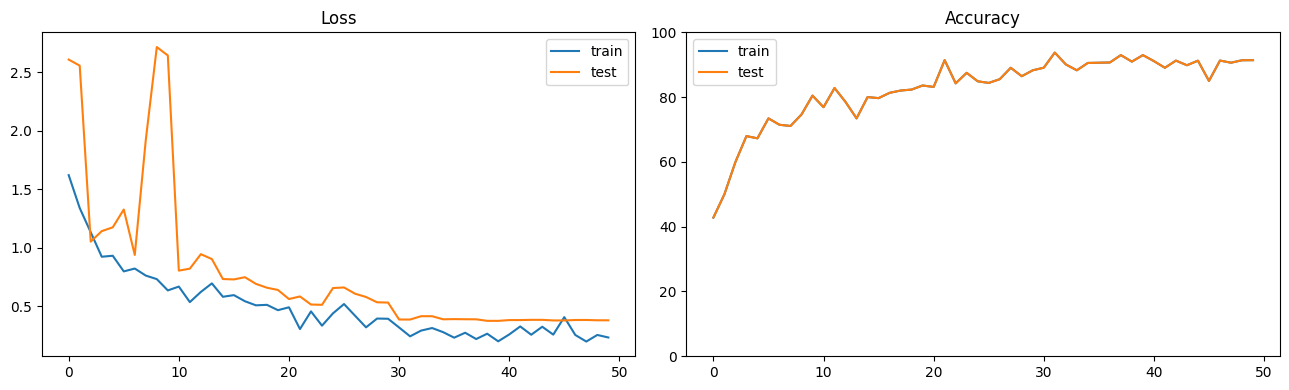

In [17]:
import matplotlib.pyplot as plt
plot_history(history)

In [18]:
model.save("cifar10_inception_result_update.keras")

In [19]:
model.save_weights("cifar10_inception_result_update.weights.h5")

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Переміщення файлу на Google Drive
!cp /content/cifar10_inception_result_update.keras "/content/drive/MyDrive/Colab Notebooks/Cifar10"

In [24]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Завантаження моделі
model_path = '/content/drive/MyDrive/Colab Notebooks/Cifar10/cifar10_inception_result_update.keras'
model = tf.keras.models.load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: dog


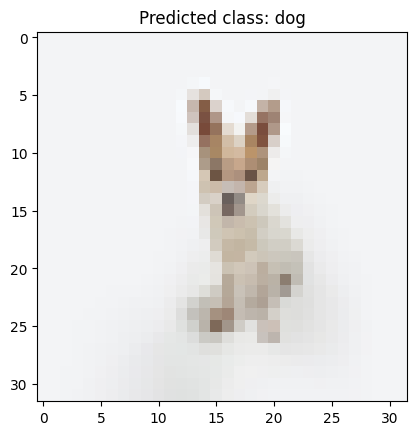

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: truck


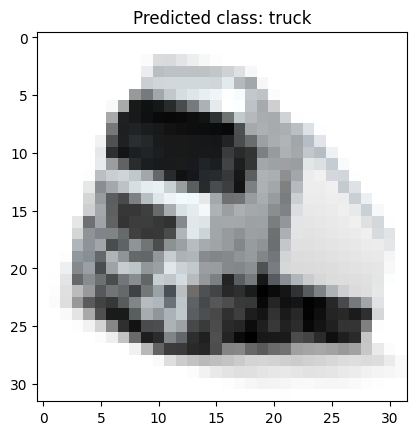

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: automobile


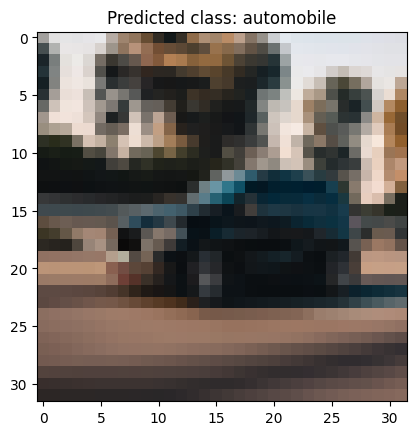

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: bird


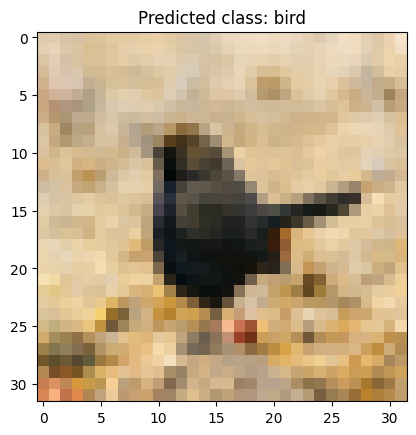

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: cat


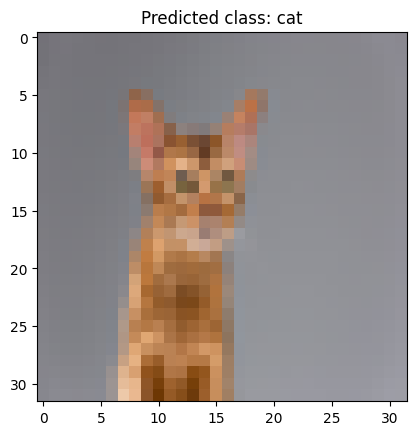

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: horse


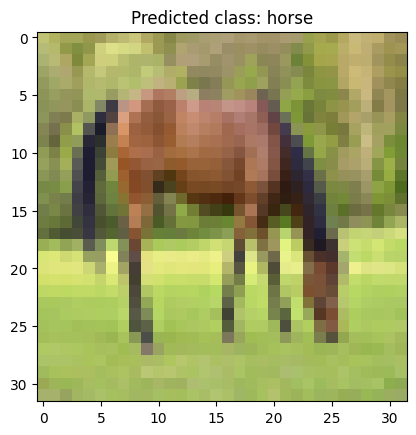

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: frog


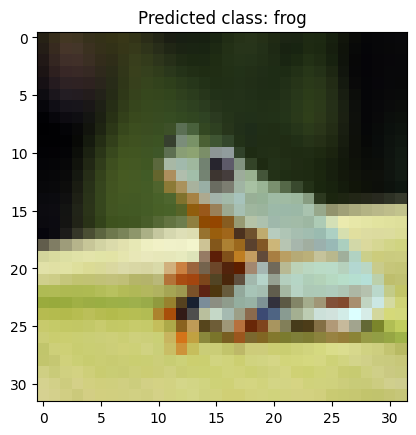

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: ship


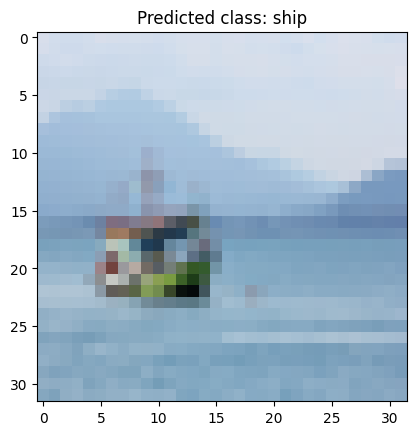

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: airplane


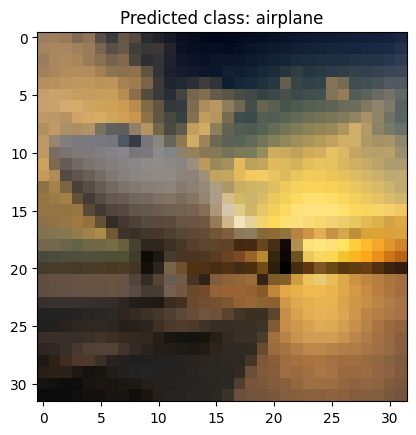

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: truck


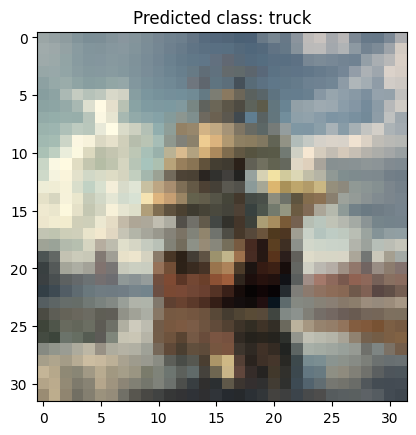

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: bird


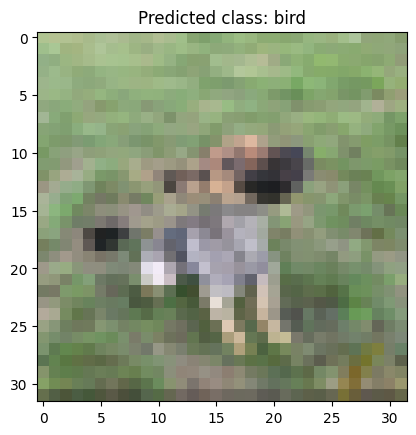

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: airplane


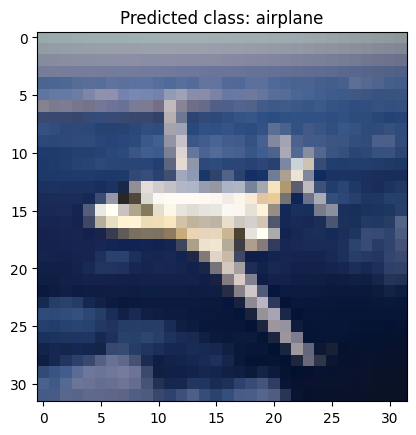

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: cat


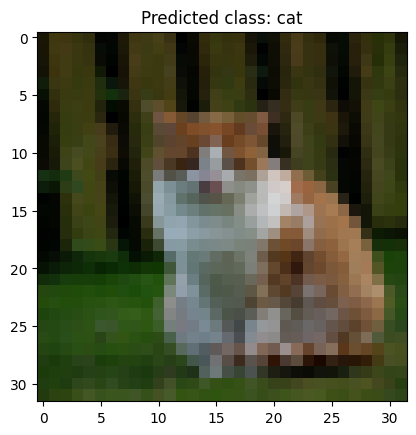

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: horse


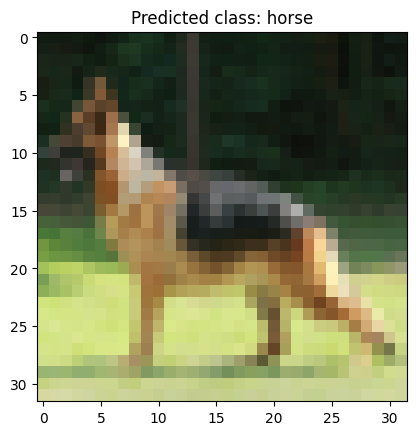

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: deer


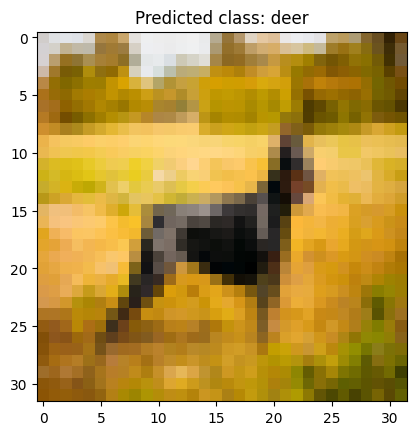

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: deer


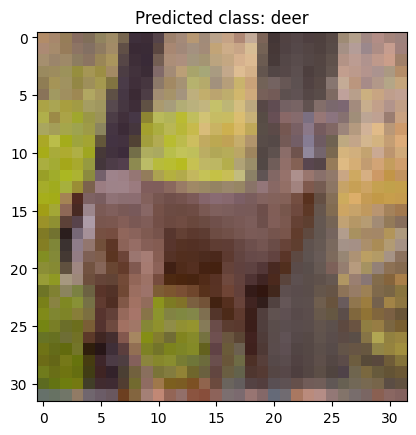

In [31]:
# Завантаження зображення з локального файлу
# Вказати шлях до файлу на Google Диску

import os


my_list = [i for i in os.listdir('/content/drive/MyDrive/Colab Notebooks/Cifar10/img') if i.lower().endswith(('.jpg'))]


# Завантаження зображення

def predict_image(file):

  img = Image.open(file)

  # Підготовка зображення
  img = img.resize((32, 32))  # зміна розміру зображення до розмірів CIFAR-10
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array.astype('float32') / 255.0  # нормалізація зображення

  # Передбачення
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions[0])

  # Класи CIFAR-10
  class_names = [
      'airplane', 'automobile', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]

  # Виведення результату
  print(f"Predicted class: {class_names[predicted_class]}")
  plt.imshow(img)
  plt.title(f"Predicted class: {class_names[predicted_class]}")
  plt.show()


for i in my_list:
  predict_image(f'/content/drive/MyDrive/Colab Notebooks/Cifar10/img/{i}')